In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
# librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# transformación de datos
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Separar datos para train y test
from sklearn.model_selection import train_test_split

# modelo de datos y métricas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# serializar el modelo
import joblib

# Desarrollo de una API
from flask import Flask, request, jsonify
from threading import Thread
import json
import os
import requests

In [81]:
df = pd.read_csv('/content/synthetic_customer_data.csv')
df.head()

,customer_id,age,gender,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment
0,CUST_0001,56,Male,65648,49624.926758,17,467.729972,52.525842,0,235,61,medium_value
1,CUST_0002,69,Male,123537,46357.348299,196,874.799829,11.120875,0,182,48,medium_value
2,CUST_0003,46,Male,145991,27043.860801,175,207.419293,86.816930,0,199,50,medium_value
3,CUST_0004,32,Female,29516,42117.461389,25,131.749484,29.736153,0,356,32,medium_value
4,CUST_0005,60,Male,132863,26095.803066,94,289.081236,16.253799,1,245,29,high_value


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               1000 non-null   object 
 1   age                       1000 non-null   int64  
 2   gender                    1000 non-null   object 
 3   annual_income             1000 non-null   int64  
 4   total_spent               1000 non-null   float64
 5   num_purchases             1000 non-null   int64  
 6   avg_purchase_value        1000 non-null   float64
 7   online_activity_score     1000 non-null   float64
 8   loyalty_program           1000 non-null   int64  
 9   days_since_last_purchase  1000 non-null   int64  
 10  num_site_visits           1000 non-null   int64  
 11  customer_segment          1000 non-null   object 
dtypes: float64(3), int64(6), object(3)
memory usage: 93.9+ KB


In [83]:
for i in df.columns:
    if df[i].nunique() < 10:
        print(f'COLUMN: {i}')
        print(f'UNIQUE VALUES: {df[i].unique()}\n')

COLUMN: gender
UNIQUE VALUES: ['Male' 'Female']

COLUMN: loyalty_program
UNIQUE VALUES: [0 1]

COLUMN: customer_segment
UNIQUE VALUES: ['medium_value' 'high_value' 'low_value']



In [84]:
original_df = df.copy()

In [85]:
# Crear una instancia del OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

encoded_data = encoder.fit_transform(df[['gender']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['gender']))

df = pd.concat([df.drop(['gender'], axis = 1), encoded_df], axis=1)
df

,customer_id,age,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment,gender_Female,gender_Male
0,CUST_0001,56,65648,49624.926758,17,467.729972,52.525842,0,235,61,medium_value,0.0,1.0
1,CUST_0002,69,123537,46357.348299,196,874.799829,11.120875,0,182,48,medium_value,0.0,1.0
2,CUST_0003,46,145991,27043.860801,175,207.419293,86.816930,0,199,50,medium_value,0.0,1.0
3,CUST_0004,32,29516,42117.461389,25,131.749484,29.736153,0,356,32,medium_value,1.0,0.0
4,CUST_0005,60,132863,26095.803066,94,289.081236,16.253799,1,245,29,high_value,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,CUST_0996,60,92982,8430.959128,156,731.840015,61.506463,1,15,43,medium_value,1.0,0.0
996,CUST_0997,64,122747,35680.997927,73,139.678658,17.567210,0,333,44,medium_value,0.0,1.0
997,CUST_0998,62,75922,33352.632138,120,201.651024,51.318989,0,58,7,medium_value,1.0,0.0
998,CUST_0999,35,68231,48305.770506,56,184.615637,71.538102,0,176,79,medium_value,0.0,1.0


In [86]:
X = df.drop(['customer_id','customer_segment'], axis = 1)
y = df['customer_segment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
for x,i in zip('X_train, X_test, y_train, y_test'.split(', '), [X_train, X_test, y_train, y_test]):
    print(f'{x}\t{i.shape}')

X_train	(800, 11)
X_test	(200, 11)
y_train	(800,)
y_test	(200,)


In [88]:
# Crear un modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [89]:
# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 98.00%


In [90]:
# Reporte de clasificación
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

  high_value       1.00      0.86      0.92        28
medium_value       0.98      1.00      0.99       172

    accuracy                           0.98       200
   macro avg       0.99      0.93      0.96       200
weighted avg       0.98      0.98      0.98       200



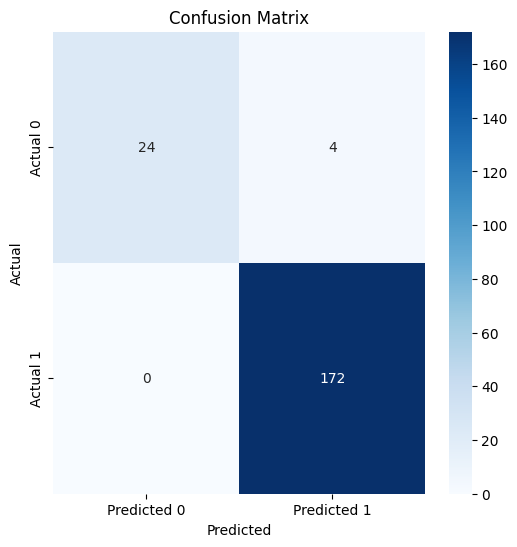

In [91]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Crea un mapa de calor usando seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

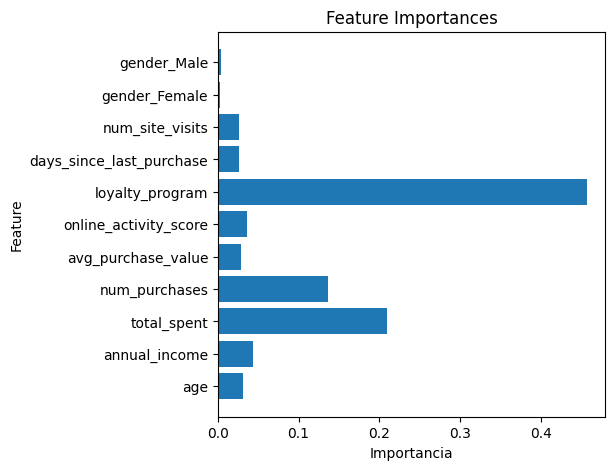

In [92]:
# Obtener la importancia de las características
feature_names = rf_model.feature_names_in_
feature_importances = rf_model.feature_importances_

# Visualizar la importancia de las características
plt.figure(figsize=(5, 5))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [93]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [94]:
random_states = []

# for n in range(0,100):
for n in range(0,1):
    # Crear un modelo de Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state = n, criterion = 'entropy')

    # Entrenar el modelo
    rf_model.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred = rf_model.predict(X_test)

    # Calcular la precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > 0.99:
        print(f"Precisión del modelo {n}: {accuracy * 100:.2f}%")

In [95]:
# Crear un modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=75, criterion = 'entropy')

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Reporte de clasificación
class_report = classification_report(y_test, y_pred)
print(class_report)

Precisión del modelo: 99.50%
              precision    recall  f1-score   support

  high_value       1.00      0.96      0.98        28
medium_value       0.99      1.00      1.00       172

    accuracy                           0.99       200
   macro avg       1.00      0.98      0.99       200
weighted avg       1.00      0.99      0.99       200



In [96]:
!pip install mlflow

In [97]:
!pip install pyngrok

In [98]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [99]:
mlflow.set_experiment('proyecto')

<Experiment: artifact_location='file:///content/mlruns/672884054303089840', creation_time=1731966405205, experiment_id='672884054303089840', last_update_time=1731966405205, lifecycle_stage='active', name='proyecto', tags={}>

In [100]:

if mlflow.active_run() is not None:
    mlflow.end_run()

with mlflow.start_run():
    # Define y entrena el modelo
    rf_model = RandomForestClassifier(n_estimators=10)
    rf_model.fit(X_train, y_train)


    mlflow.log_param("n_estimators", 10)
    mlflow.log_param("criterion", "entropy")




In [101]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 99.00%


In [102]:
mlflow.sklearn.log_model(rf_model,"RandomForestModel") ##serializaciondelmodelo

2024/11/18 23:46:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [103]:
get_ipython().system_raw("mlflow ui--port 5000 &")  ##activar el servidor

In [107]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pyngrok import ngrok
import os

# ... (Tu código para cargar y preparar los datos - X_train, y_train, X_test, y_test)

# 1. Configura MLflow y el experimento
mlflow.set_experiment('proyecto')

if mlflow.active_run() is not None:
    mlflow.end_run()


with mlflow.start_run():
    # 2. Entrena y registra el modelo
    rf_model = RandomForestClassifier(n_estimators=100, random_state=75, criterion="entropy") # Mejor modelo según tus experimentos
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión del modelo: {accuracy * 100:.2f}%")

    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("random_state", 75)
    mlflow.log_param("criterion", "entropy")
    mlflow.log_metric("accuracy", accuracy)

    mlflow.sklearn.log_model(rf_model, "RandomForestModel")

# 3. Inicia la UI de MLflow *antes* de conectar ngrok
get_ipython().system_raw("mlflow ui --port 5000 &")

# 4. Configura y conecta ngrok *después* de iniciar MLflow UI
ngrok.kill()  # Mata cualquier túnel existente

# Asegúrate de tener tu token de autenticación de ngrok
NGROK_AUTH_TOKEN = os.environ.get("NGROK_AUTH_TOKEN")  # Obtener de variable de entorno
if NGROK_AUTH_TOKEN is None:
    print("Error: Debes configurar la variable de entorno NGROK_AUTH_TOKEN con tu token.")
else:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("Url para MLFLOW: ", ngrok_tunnel.public_url)

Precisión del modelo: 99.50%


2024/11/18 23:58:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error: Debes configurar la variable de entorno NGROK_AUTH_TOKEN con tu token.


In [108]:
from pyngrok import ngrok
ngrok.kill()

NGROK_AUTH_TOKEN = "2p2pMmzd9QoS0IEGW2mHDj7mOA4_5EZWYbLby6G1ChauJVRxm"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel= ngrok.connect(addr="5000",proto="http",bind_tls=True)
print("Url para MLFLOW: ",ngrok_tunnel.public_url)

Url para MLFLOW:  https://b0c5-34-125-244-145.ngrok-free.app
